# Preparation #

In [2]:
!pip -q install datasets evaluate transformers

In [21]:
import gc
import os
import dotenv
import torch
import evaluate
import numpy as np
import huggingface_hub
from datasets import Dataset
import os, json, pandas as pd
import matplotlib.pyplot as plt
from huggingface_hub import hf_hub_download
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from transformers import TrainingArguments, Trainer, DataCollatorWithPadding, DeBERTaTokenizer, AutoModelForSequenceClassification

dotenv.load_dotenv()
HUGGING_FACE_API_KEY = os.getenv('HUGGING_FACE_API_KEY')

ImportError: cannot import name 'DeBERTaTokenizer' from 'transformers' (c:\unimelb\2025 sem 1\nlp\as3\NLP_PRJ\venv\Lib\site-packages\transformers\__init__.py)

### Set Model ###

In [7]:
model_name = "microsoft/deberta-v2-xlarge-mnli"

### Login Hugginface ###

In [8]:
huggingface_hub.login(HUGGING_FACE_API_KEY)

## Use Model ##

In [9]:
# Make sure CUDA is available
assert torch.cuda.is_available(), "CUDA is not available!"
print(torch.cuda.get_device_name())

NVIDIA GeForce GTX 1660 Ti


## Load Data ##

In [10]:
DATA_DIR   = "./data"
TRAIN_FILE = os.path.join(DATA_DIR, "train-claims.json")
DEV_FILE   = os.path.join(DATA_DIR, "dev-claims.json")
TEST_FILE  = os.path.join(DATA_DIR, "test-claims-unlabelled.json")
EVID_FILE  = os.path.join(DATA_DIR, "evidence.json")


def load_claims(path: str, labelled: bool = True) -> pd.DataFrame:

    with open(path, "r", encoding="utf-8") as f:
        raw = json.load(f)

    rows = []
    for cid, info in raw.items():
        row = {
            "claim_id":   cid,
            "claim_text": info.get("claim_text", "")
        }
        if labelled:
            row["label"]      = info["claim_label"]
            row["evid_ids"]   = info["evidences"]     # list[str]
        rows.append(row)

    df = pd.DataFrame(rows)


    if labelled:
        df["label"] = df["label"].astype("category")

    return df


def load_evidence(path: str):

    with open(path, "r", encoding="utf-8") as f:
        raw = json.load(f)

    df   = pd.DataFrame([{"evid_id": k, "evid_text": v} for k, v in raw.items()])
    edict = {k: v for k, v in raw.items()}
    return df, edict



df_train = load_claims(TRAIN_FILE, labelled=True)
df_dev   = load_claims(DEV_FILE,   labelled=True)
df_test  = load_claims(TEST_FILE,  labelled=False)

df_evid, evid_dict = load_evidence(EVID_FILE)


LABEL2ID = {"SUPPORTS": 0, "REFUTES": 1, "NOT_ENOUGH_INFO": 2, "DISPUTED": 3}
ID2LABEL = {v: k for k, v in LABEL2ID.items()}

for df in (df_train, df_dev):
    df["label_id"] = df["label"].map(LABEL2ID).astype("int8")

print(f"Train size: {len(df_train):,}")
print(f"Dev   size: {len(df_dev):,}")
print(f"Test  size: {len(df_test):,}")
print(f"Evidence passages: {len(df_evid):,}")

display(df_train.head())
display(df_evid.head())

print("Train label distribution:")
display(df_train["label"].value_counts())

print("Dev label distribution:")
display(df_dev["label"].value_counts())


Train size: 1,228
Dev   size: 154
Test  size: 153
Evidence passages: 1,208,827


,claim_id,claim_text,label,evid_ids,label_id
0,claim-1937,Not only is there no scientific evidence that ...,DISPUTED,"[evidence-442946, evidence-1194317, evidence-1...",3
1,claim-126,El Niño drove record highs in global temperatu...,REFUTES,"[evidence-338219, evidence-1127398]",1
2,claim-2510,"In 1946, PDO switched to a cool phase.",SUPPORTS,"[evidence-530063, evidence-984887]",0
3,claim-2021,Weather Channel co-founder John Coleman provid...,DISPUTED,"[evidence-1177431, evidence-782448, evidence-5...",3
4,claim-2449,"""January 2008 capped a 12 month period of glob...",NOT_ENOUGH_INFO,"[evidence-1010750, evidence-91661, evidence-72...",2


,evid_id,evid_text
0,evidence-0,"John Bennet Lawes, English entrepreneur and ag..."
1,evidence-1,Lindberg began his professional career at the ...
2,evidence-2,``Boston (Ladies of Cambridge)'' by Vampire We...
3,evidence-3,"Gerald Francis Goyer (born October 20, 1936) w..."
4,evidence-4,He detected abnormalities of oxytocinergic fun...


Train label distribution:


label
SUPPORTS           519
NOT_ENOUGH_INFO    386
REFUTES            199
DISPUTED           124
Name: count, dtype: int64

Dev label distribution:


label
SUPPORTS           68
NOT_ENOUGH_INFO    41
REFUTES            27
DISPUTED           18
Name: count, dtype: int64

# Four class classification #

## Preprocess Data ##

In [11]:
# First, create a dictionary mapping evid_id to evid_text for faster lookup
evid_dict = dict(zip(df_evid['evid_id'], df_evid['evid_text']))

# Create a new column for evidence text
df_train['evid_text'] = df_train['evid_ids'].apply(lambda x: " ".join([evid_dict[evid_id] for evid_id in x]))
df_dev['evid_text'] = df_dev['evid_ids'].apply(lambda x: " ".join([evid_dict[evid_id] for evid_id in x]))

df_train['labels'] = df_train['label_id']
df_dev['labels'] = df_dev['label_id']

df_train_processed = df_train[['claim_text', 'labels', 'evid_text']]
df_dev_processed = df_dev[['claim_text', 'labels', 'evid_text']]
print(df_train[['claim_text', 'labels', 'evid_text']].head())
print(df_dev[['claim_text', 'labels', 'evid_text']].head())


                                          claim_text  labels  \
0  Not only is there no scientific evidence that ...       3   
1  El Niño drove record highs in global temperatu...       1   
2             In 1946, PDO switched to a cool phase.       0   
3  Weather Channel co-founder John Coleman provid...       3   
4  "January 2008 capped a 12 month period of glob...       2   

                                           evid_text  
0  At very high concentrations (100 times atmosph...  
1  While ‘climate change’ can be due to natural f...  
2  There is evidence of reversals in the prevaili...  
3  There is no convincing scientific evidence tha...  
4  With average temperature +8.1 °C (47 °F). The ...  
                                          claim_text  labels  \
0  [South Australia] has the most expensive elect...       0   
1  when 3 per cent of total annual global emissio...       2   
2  This means that the world is now 1C warmer tha...       0   
3  “As it happens, Zika may a

## Get Sample ##

In [12]:
sample_df_train = df_train_processed
sample_df_dev = df_dev_processed

## Add class weight ##

In [13]:
label_counts = sample_df_train['labels'].value_counts()

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.arange(len(label_counts)),
    y=np.concatenate([[i] * count for i, count in enumerate(label_counts)])
)
class_weights = torch.tensor(class_weights, dtype=torch.float)
class_weights

tensor([0.5915, 0.7953, 1.5427, 2.4758])

## Custom loss function based on class weight ##

In [14]:
class WeightedTrainer(Trainer):
  def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
    labels = inputs.get("labels")
    outputs = model(**inputs)
    logits = outputs.get("logits")
    loss_fct = torch.nn.CrossEntropyLoss(weight=class_weights.to(model.device))
    loss = loss_fct(logits, labels)
    return (loss, outputs) if return_outputs else loss

## Tokenize Dataset ##

In [18]:
tokenizer = AutoTokenizer.from_pretrained(model_name)

def preprocess_function(examples):
    return tokenizer(
        examples["claim_text"],
        examples["evid_text"],
        truncation=True,
        padding="max_length",
        max_length=512,
    )

# Convert to HuggingFace dataset
# Assuming `data` is a list of dicts or a DataFrame
dataset_train = Dataset.from_pandas(sample_df_train)  # or from_dict(data)
tokenized_dataset_train = dataset_train.map(preprocess_function, batched=True)

dataset_dev = Dataset.from_pandas(sample_df_dev)  # or from_dict(data)
tokenized_dataset_dev = dataset_dev.map(preprocess_function, batched=True)


ValueError: Converting from SentencePiece and Tiktoken failed, if a converter for SentencePiece is available, provide a model path with a SentencePiece tokenizer.model file.Currently available slow->fast converters: ['AlbertTokenizer', 'BartTokenizer', 'BarthezTokenizer', 'BertTokenizer', 'BigBirdTokenizer', 'BlenderbotTokenizer', 'CamembertTokenizer', 'CLIPTokenizer', 'CodeGenTokenizer', 'ConvBertTokenizer', 'DebertaTokenizer', 'DebertaV2Tokenizer', 'DistilBertTokenizer', 'DPRReaderTokenizer', 'DPRQuestionEncoderTokenizer', 'DPRContextEncoderTokenizer', 'ElectraTokenizer', 'FNetTokenizer', 'FunnelTokenizer', 'GPT2Tokenizer', 'HerbertTokenizer', 'LayoutLMTokenizer', 'LayoutLMv2Tokenizer', 'LayoutLMv3Tokenizer', 'LayoutXLMTokenizer', 'LongformerTokenizer', 'LEDTokenizer', 'LxmertTokenizer', 'MarkupLMTokenizer', 'MBartTokenizer', 'MBart50Tokenizer', 'MPNetTokenizer', 'MobileBertTokenizer', 'MvpTokenizer', 'NllbTokenizer', 'OpenAIGPTTokenizer', 'PegasusTokenizer', 'Qwen2Tokenizer', 'RealmTokenizer', 'ReformerTokenizer', 'RemBertTokenizer', 'RetriBertTokenizer', 'RobertaTokenizer', 'RoFormerTokenizer', 'SeamlessM4TTokenizer', 'SqueezeBertTokenizer', 'T5Tokenizer', 'UdopTokenizer', 'WhisperTokenizer', 'XLMRobertaTokenizer', 'XLNetTokenizer', 'SplinterTokenizer', 'XGLMTokenizer', 'LlamaTokenizer', 'CodeLlamaTokenizer', 'GemmaTokenizer', 'Phi3Tokenizer']

In [13]:
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=4,
    id2label=ID2LABEL,
    label2id=LABEL2ID,
    ignore_mismatched_sizes=True,
).to("cuda")


Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v2-xlarge-mnli and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([3, 1536]) in the checkpoint and torch.Size([4, 1536]) in the model instantiated
- classifier.bias: found shape torch.Size([3]) in the checkpoint and torch.Size([4]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Train ##

In [23]:
training_args = TrainingArguments(
    output_dir="./results",
    learning_rate=3e-6,
    per_device_train_batch_size=1,
    per_device_eval_batch_size=1,
    num_train_epochs=5,
    weight_decay=0.01,
    gradient_accumulation_steps=4,
    fp16=True,
    dataloader_pin_memory=False
)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

trainer = WeightedTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset_train,
    eval_dataset=tokenized_dataset_dev,  # optional
    tokenizer=tokenizer,
    data_collator=data_collator,
)

<ipython-input-23-0b2d2fe890bc>:17: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  trainer = WeightedTrainer(


In [24]:
trainer.train()

OutOfMemoryError: CUDA out of memory. Tried to allocate 12.00 MiB. GPU 0 has a total capacity of 14.74 GiB of which 2.12 MiB is free. Process 63950 has 14.74 GiB memory in use. Of the allocated memory 14.36 GiB is allocated by PyTorch, and 243.80 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

## Evaluation ##

In [51]:
predictions = trainer.predict(tokenized_dataset_dev)

preds = np.argmax(predictions.predictions, axis=1)
labels = predictions.label_ids

# Calculate accuracy
accuracy = evaluate.load("accuracy")
accuracy.compute(predictions=preds, references=predictions.label_ids)
f1 = evaluate.load("f1")
f1.compute(predictions=preds, references=predictions.label_ids, average='macro')


{'f1': 0.7459073619938942}

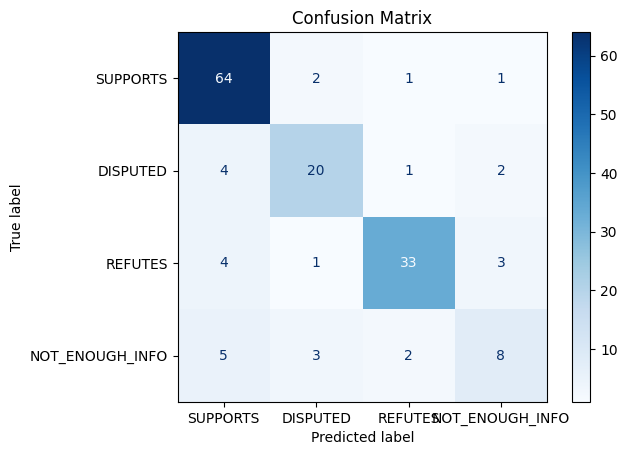

In [52]:
# Compute the matrix
cm = confusion_matrix(labels, preds)

# Optionally, if you have label names:
label_names = ["SUPPORTS", "DISPUTED", "REFUTES", "NOT_ENOUGH_INFO"]

# Display it
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)
disp.plot(cmap="Blues", values_format='d')
plt.title("Confusion Matrix")
plt.show()

## Re-train on Hard Negatives ##

In [25]:
# Retrieve all the "NOT_ENOUGH_INFO" labels with the same amount of other labels
# and retrain them

sample_df_train_not_enough_info = sample_df_train.loc[sample_df_train['labels'] == 3]
sample_df_train_rest = sample_df_train.loc[sample_df_train['labels'] != 3].sample(len(sample_df_train_not_enough_info))
sample_df_train_hard_negatives = pd.concat([sample_df_train_not_enough_info, sample_df_train_rest])

dataset_train_hard_negatives = Dataset.from_pandas(sample_df_train_hard_negatives)  # or from_dict(data)
tokenized_dataset_train_hard_negatives = dataset_train_hard_negatives.map(preprocess_function, batched=True)

Map:   0%|          | 0/248 [00:00<?, ? examples/s]

In [28]:
# update trainer and train again
training_args = TrainingArguments(
    output_dir="./results",
    learning_rate=3e-6,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=10,
    weight_decay=0.01,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset_train_hard_negatives,
    eval_dataset=tokenized_dataset_dev,  # optional
    tokenizer=tokenizer,
    data_collator=data_collator,
)

# continue training
trainer.train(resume_from_checkpoint=True)

<ipython-input-28-c60865fcc947>:11: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss


TrainOutput(global_step=921, training_loss=0.0, metrics={'train_runtime': 0.0148, 'train_samples_per_second': 167577.554, 'train_steps_per_second': 41894.388, 'total_flos': 7802247709900800.0, 'train_loss': 0.0, 'epoch': 3.0})

In [29]:
predictions = trainer.predict(tokenized_dataset_dev)

preds = np.argmax(predictions.predictions, axis=1)
labels = predictions.label_ids

# Calculate accuracy
accuracy = evaluate.load("accuracy")
accuracy.compute(predictions=preds, references=predictions.label_ids)
f1 = evaluate.load("f1")
f1.compute(predictions=preds, references=predictions.label_ids, average='macro')

{'f1': 0.624204862968908}

## Free cached memory ##

In [20]:
gc.collect()
torch.cuda.empty_cache()

# LoRa with Bert #

In [14]:
!pip -q install peft

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 123.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 98.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 65.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 42.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 20.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 108.3 MB/s eta 0:00:00


## Wrap LoRa Around Model ##

In [43]:
from peft import get_peft_model, LoraConfig, TaskType
model.unload()
lora_config = LoraConfig(
    task_type=TaskType.SEQ_CLS,
    r=32,
    lora_alpha=32,
    lora_dropout=0.1,
    bias="none",
)

# Wrap model with Lora
model = get_peft_model(model, lora_config)

/usr/local/lib/python3.11/dist-packages/peft/tuners/tuners_utils.py:167: UserWarning: Already found a `peft_config` attribute in the model. This will lead to having multiple adapters in the model. Make sure to know what you are doing!
  warnings.warn(


In [33]:
from sklearn.metrics import accuracy_score, f1_score
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    acc = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average="weighted")  # or "macro" if class imbalance
    return {"accuracy": acc, "f1": f1}

In [48]:
training_args = TrainingArguments(
    output_dir="./results",
    learning_rate=8e-6,                  # ⬆️ Slightly increase to help LoRA layers adapt
    per_device_train_batch_size=2,     # ⬆️ Increase if your GPU allows (better gradient estimates)
    per_device_eval_batch_size=2,
    num_train_epochs=10,                 # ⬆️ Train longer (2 epochs is very low)
    weight_decay=0.01,
    fp16=True,
    dataloader_pin_memory=True,         # ⬆️ Enable for slight speed-up unless it caused issues
    label_names=["labels"],
    run_name="Lora-Bert",
    metric_for_best_model="f1",         # ⬅️ Assuming you're tracking F1
    greater_is_better=True,
    gradient_accumulation_steps=4,
    lr_scheduler_type="cosine",
    eval_steps=200,  # or whatever interval works for you
    logging_strategy="steps",
    logging_steps=200,
    save_strategy="steps",
    save_steps=200,
)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

trainer = WeightedTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset_train,
    eval_dataset=tokenized_dataset_dev,  # optional
    processing_class=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

#trainer.label_names = ["SUPPORTS", "REFUTES", "NOT_ENOUGH_INFO", "DISPUTED"]

In [16]:
!wandb login {userdata.get('WANDB_API_KEY')}

wandb: WARNING Using legacy-service, which is deprecated. If this is unintentional, you can fix it by ensuring you do not call `wandb.require('legacy-service')` and do not set the WANDB_X_REQUIRE_LEGACY_SERVICE environment variable.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin


In [49]:
trainer.train()

Step,Training Loss
200,4.266900
400,3.939700
600,3.752100
800,3.588200
1000,3.447400
1200,3.398200
1400,3.243600


TrainOutput(global_step=1530, training_loss=3.633128965290543, metrics={'train_runtime': 1009.0276, 'train_samples_per_second': 12.17, 'train_steps_per_second': 1.516, 'total_flos': 2.602366769774592e+16, 'train_loss': 3.633128965290543, 'epoch': 9.938110749185668})

In [50]:
predictions = trainer.predict(tokenized_dataset_dev)

preds = np.argmax(predictions.predictions, axis=1)
labels = predictions.label_ids

# Calculate accuracy
accuracy = evaluate.load("accuracy")
accuracy.compute(predictions=preds, references=predictions.label_ids)
f1 = evaluate.load("f1")
f1.compute(predictions=preds, references=predictions.label_ids, average='macro')

{'f1': 0.5359003831417625}

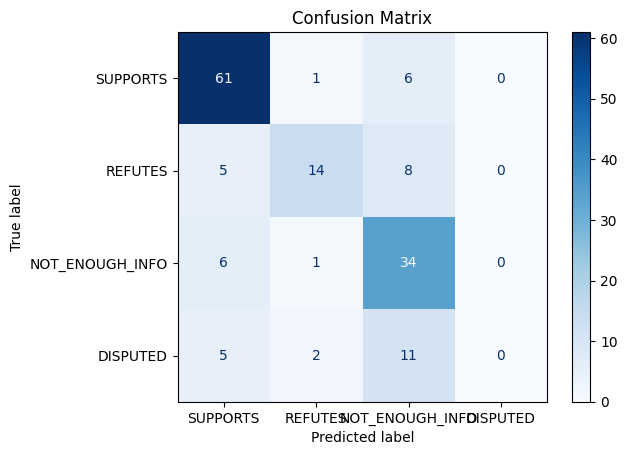

In [51]:
# Compute the matrix
cm = confusion_matrix(labels, preds)

# Optionally, if you have label names:
label_names = ["SUPPORTS", "REFUTES", "NOT_ENOUGH_INFO", "DISPUTED"]
# Display it
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)
disp.plot(cmap="Blues", values_format='d')
plt.title("Confusion Matrix")
plt.show()